In [6]:
from os import path
import glob
import re
import matplotlib.pyplot as plt
import subprocess

In [23]:
folder = 'set_two'
files = glob.glob(f'files/{folder}/*')
files.sort()
files

['files/set_two/1677511696683-67eedcee-98bf-4f05-90f7-9e8ed2ce58cb-cam-audio-1677511704290.webm',
 'files/set_two/1677511696683-67eedcee-98bf-4f05-90f7-9e8ed2ce58cb-cam-video-1677511704293.mp4',
 'files/set_two/1677511696683-67eedcee-98bf-4f05-90f7-9e8ed2ce58cb-cam-video-1677511704293.webm',
 'files/set_two/1677511696683-fc210681-bd73-4bfc-ac8d-1c5c606a9bd0-cam-audio-1677511697662.webm',
 'files/set_two/1677511696683-fc210681-bd73-4bfc-ac8d-1c5c606a9bd0-cam-video-1677511697670.mp4',
 'files/set_two/1677511696683-fc210681-bd73-4bfc-ac8d-1c5c606a9bd0-cam-video-1677511697670.webm']

In [24]:
import subprocess

group_data = {}
for filepath in files:
    if ".webm" not in filepath:
        continue
    basename = path.basename(filepath)
    participant_id = "-".join(basename.split("-")[1:-3])
    track_type = basename.split("-")[-2]
    track_start = int(basename.split("-")[-1].split(".")[0])
    group_start = int(basename.split("-")[0])

    if participant_id not in group_data:
        group_data[participant_id] = {
        "participant_id": participant_id,
        "group_start": int(basename.split("-")[0]),
        "dirname": path.dirname(filepath),
    }
        
    result = subprocess.run(['ffprobe', filepath], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    probe = result.stderr.splitlines()

    # get start offset
    line = [line  for line in probe if "start: " in line][0]
    start = re.search(r'start: (\d+\.\d+)', line).group(1)
    group_data[participant_id][track_type+"_track_start"] = start

    if track_type == "video":
        # get resolution
        line = [line  for line in probe if "Stream " in line][0]
        resolution = re.search(r'\d+x\d+', line).group(0)
        group_data[participant_id][track_type+"_resolution"] = resolution


    group_data[participant_id][track_type] = filepath
    group_data[participant_id][track_type+"_start"] = track_start
    group_data[participant_id][track_type+"_offset"] = track_start - group_start


group_data

{'67eedcee-98bf-4f05-90f7-9e8ed2ce58cb': {'participant_id': '67eedcee-98bf-4f05-90f7-9e8ed2ce58cb',
  'group_start': 1677511696683,
  'dirname': 'files/set_two',
  'audio_track_start': '7.659000',
  'audio': 'files/set_two/1677511696683-67eedcee-98bf-4f05-90f7-9e8ed2ce58cb-cam-audio-1677511704290.webm',
  'audio_start': 1677511704290,
  'audio_offset': 7607,
  'video_track_start': '8.467000',
  'video_resolution': '1280x720',
  'video': 'files/set_two/1677511696683-67eedcee-98bf-4f05-90f7-9e8ed2ce58cb-cam-video-1677511704293.webm',
  'video_start': 1677511704293,
  'video_offset': 7610},
 'fc210681-bd73-4bfc-ac8d-1c5c606a9bd0': {'participant_id': 'fc210681-bd73-4bfc-ac8d-1c5c606a9bd0',
  'group_start': 1677511696683,
  'dirname': 'files/set_two',
  'audio_track_start': '0.946000',
  'audio': 'files/set_two/1677511696683-fc210681-bd73-4bfc-ac8d-1c5c606a9bd0-cam-audio-1677511697662.webm',
  'audio_start': 1677511697662,
  'audio_offset': 979,
  'video_track_start': '1.731000',
  'video_r

# FFMPEG notes:


## Commands
- commands generally list inputs with `-i filename` then have filters, then have and output.
- Flags for inputs (or outputs) go in front of the input (output) they apply to, and if you have multiple inputs you can apply the flag to then individually

## Filters
- ffmpeg filters are made of chains of different filters. Different chains are separated by a semicolon, filters within a chain by a comma
- filter consists of selectors (e.g.`[0:a][1:a]` etc.) then filter commands, then outputs []

### Audio

#### To split a stereo to mono:
```
ffmpeg -i stereo.wav -filter_complex "[0:a]channelsplit=channel_layout=stereo:channels=FR[right]" -map "[right]" front_right.wav
```

#### To merge 6 mono tracks to one multichannel output
```
ffmpeg -i front_left.wav -i front_right.wav -i front_center.wav -i lfe.wav -i back_left.wav -i back_right.wav \
-filter_complex "[0:a][1:a][2:a][3:a][4:a][5:a]join=inputs=6:channel_layout=5.1[a]" -map "[a]" output.wav
```

#### combine all audio tracks into one audio track
- use the amerge filter to take audio streams from different files and add them as separate streams to the output
```
[0:a][1:a]amerge=inputs=2,
```
the output of this can be fed to a single stereo stream:
```
pan=mono|c0<c0+c1+c2+c3|
```

### Video

#### Stack videos:
https://ffmpeg.org/ffmpeg-filters.html#xstack-1

# Notes on our videos

The input videos have variable frame rate, it seems, so we re-encode using the output flag `-r 30` to get 30FPS

The input videos also seem to have variable resolutions (urg...) need to work out how to deal with this.

In [36]:
# format inputs
audio_inputs = [f'-itsoffset "{ group_data[i]["audio_track_start"] }" -i {group_data[i]["audio"]}' for i in group_data]
video_inputs = [f'-itsoffset "{ group_data[i]["video_track_start"] }" -i {group_data[i]["video"]}' for i in group_data]

# format audio chain
audioChain = "".join([f'[{i}:a]' for i in range(len(audio_inputs))]) + \
    f'amerge=inputs={len(audio_inputs)},' + \
    f'pan=mono|c0<{ "+".join([f"c{j}" for j in range(len(audio_inputs)*2)])}|[a]'

# format video chain
videoChain = "".join([f'[{i+len(audio_inputs)}:v]scale=1280:720[v{i}];' for i in range(len(video_inputs))]) + \
    f'{"".join([f"[v{i}]" for i in range(len(video_inputs))])}hstack=inputs={len(video_inputs)}[v]'

cmd = f'ffmpeg {" ".join(audio_inputs)} {" ".join(video_inputs)} -filter_complex "{audioChain};{videoChain}" -map "[a]" -map "[v]" -r 30 testVideos/{folder}.webm'
print(cmd)
print()
! $cmd -y

'ffmpeg -itsoffset "0.956000" -i testVideos/test1/1705678316133-89a8a334-06cb-4127-8888-636b5ac97692-cam-audio-1705678317122.webm -itsoffset "0.963000" -i testVideos/test1/1705678316133-ce3e2c98-a999-4202-8139-2bdfe5d1cec2-cam-audio-1705678317125.webm -itsoffset "2.288000" -i testVideos/test1/1705678316133-89a8a334-06cb-4127-8888-636b5ac97692-cam-video-1705678317124.webm -itsoffset "2.336000" -i testVideos/test1/1705678316133-ce3e2c98-a999-4202-8139-2bdfe5d1cec2-cam-video-1705678317126.webm -filter_complex "[0:a][1:a]amerge=inputs=2,pan=mono|c0<c0+c1+c2+c3|[a];[2:v]scale=1280:720[v0];[3:v]scale=1280:720[v1];[v0][v1]hstack=inputs=2[v]" -map "[a]" -map "[v]" -r 30 testVideos/test1.webm'

This kinda works, but the video gets stuck a lot. It doesn't handle stuck source videos well at all. If one of the source videos is missing frames, then the composed video will be stuck while all the source videos are stuck.


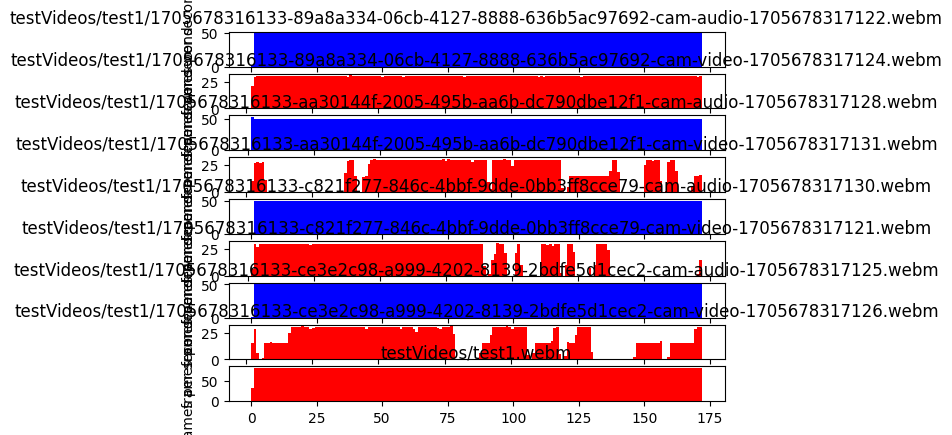

In [41]:
measure_files = files + [f'testVideos/{folder}.webm']
for i, filepath in enumerate(measure_files):
    output = ! ffprobe -show_frames $filepath
    frames = "\n".join(output).split("[FRAME]")[2:] 
    times = [float(re.search(r'pts_time=(\d+\.\d+)', frame).group(1)) for frame in frames]
    plt.subplot(len(measure_files), 1, i+1)
    plt.hist(times, bins=range(int(min(times)), int(max(times)), 1), color= "blue" if "audio" in filepath else "red")
    plt.title(filepath)

plt.ylabel("frames per second")

# Reframe each video independently
The problem was that when one webm file has problems, all the rest get stalled out too. a workaround is to resample all the videos at a constant frame rate prior to stitching them together. This is annoying, but kinda works?

In [27]:
for filepath in files:
    if filepath.endswith(".mp4") or "audio" in filepath:
        continue
    outfilePath = filepath.replace(".webm", ".mp4")
    print(filepath, outfilePath)
    command = f'ffmpeg -i "{filepath}" -r 24 "{outfilePath}" -y'
    subprocess.run(command, shell=True, check=True)

files/set_two/1677511696683-67eedcee-98bf-4f05-90f7-9e8ed2ce58cb-cam-video-1677511704293.webm files/set_two/1677511696683-67eedcee-98bf-4f05-90f7-9e8ed2ce58cb-cam-video-1677511704293.mp4
ffmpeg -i "files/set_two/1677511696683-67eedcee-98bf-4f05-90f7-9e8ed2ce58cb-cam-video-1677511704293.webm" -r 24 "files/set_two/1677511696683-67eedcee-98bf-4f05-90f7-9e8ed2ce58cb-cam-video-1677511704293.mp4" -y
files/set_two/1677511696683-fc210681-bd73-4bfc-ac8d-1c5c606a9bd0-cam-video-1677511697670.webm files/set_two/1677511696683-fc210681-bd73-4bfc-ac8d-1c5c606a9bd0-cam-video-1677511697670.mp4
ffmpeg -i "files/set_two/1677511696683-fc210681-bd73-4bfc-ac8d-1c5c606a9bd0-cam-video-1677511697670.webm" -r 24 "files/set_two/1677511696683-fc210681-bd73-4bfc-ac8d-1c5c606a9bd0-cam-video-1677511697670.mp4" -y


Text(0, 0.5, 'frames per second')

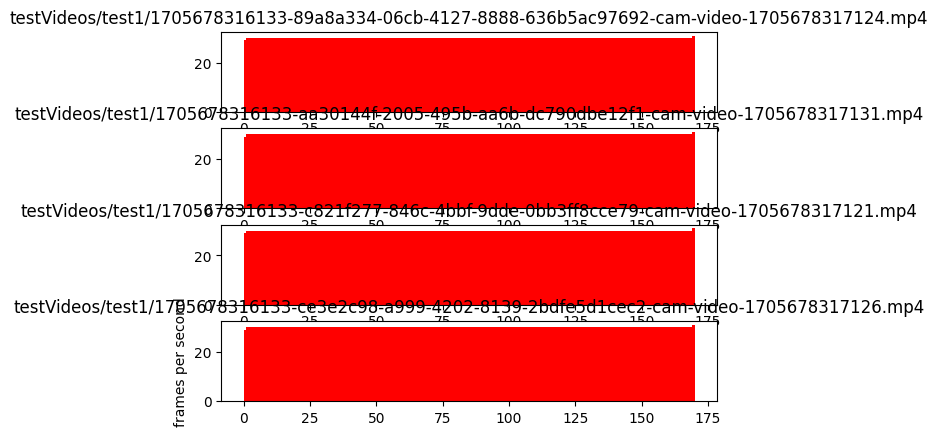

In [5]:
# i didn't run this

folder = 'set_two'
measure_files = glob.glob(f'testVideos/{folder}/*.mp4')
measure_files.sort()

for i, filepath in enumerate(measure_files):
    output = ! ffprobe -show_frames $filepath
    frames = "\n".join(output).split("[FRAME]")[2:] 
    times = [float(re.search(r'pts_time=(\d+\.\d+)', frame).group(1)) for frame in frames]
    plt.subplot(len(measure_files), 1, i+1)
    plt.hist(times, bins=range(int(min(times)), int(max(times)), 1), color= "blue" if "audio" in filepath else "red")
    plt.title(filepath)

plt.ylabel("frames per second")

In [26]:
# format inputs
audio_inputs = [f'-itsoffset "{ group_data[i]["audio_track_start"] }" -i {group_data[i]["audio"]}' for i in group_data]
video_inputs = [f'-itsoffset "{ group_data[i]["video_track_start"] }" -i {group_data[i]["video"].replace(".webm", ".mp4")}' for i in group_data]

# format audio chain
audioChain = "".join([f'[{i}:a]' for i in range(len(audio_inputs))]) + \
    f'amerge=inputs={len(audio_inputs)},' + \
    f'pan=mono|c0<{ "+".join([f"c{j}" for j in range(len(audio_inputs)*2)])}|[a]'

# format video chain
videoChain = "".join([f'[{i+len(audio_inputs)}:v]scale=1280:720[v{i}];' for i in range(len(video_inputs))]) + \
    f'{"".join([f"[v{i}]" for i in range(len(video_inputs))])}hstack=inputs={len(video_inputs)}[v]'

cmd = f'ffmpeg {" ".join(audio_inputs)} {" ".join(video_inputs)} -filter_complex "{audioChain};{videoChain}" -map "[a]" -map "[v]" files/{folder}/{folder}_resampled.mp4'

print(cmd)
result = subprocess.run(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, check=True)

ffmpeg -itsoffset "7.659000" -i files/set_two/1677511696683-67eedcee-98bf-4f05-90f7-9e8ed2ce58cb-cam-audio-1677511704290.webm -itsoffset "0.946000" -i files/set_two/1677511696683-fc210681-bd73-4bfc-ac8d-1c5c606a9bd0-cam-audio-1677511697662.webm -itsoffset "8.467000" -i files/set_two/1677511696683-67eedcee-98bf-4f05-90f7-9e8ed2ce58cb-cam-video-1677511704293.mp4 -itsoffset "1.731000" -i files/set_two/1677511696683-fc210681-bd73-4bfc-ac8d-1c5c606a9bd0-cam-video-1677511697670.mp4 -filter_complex "[0:a][1:a]amerge=inputs=2,pan=mono|c0<c0+c1+c2+c3|[a];[2:v]scale=1280:720[v0];[3:v]scale=1280:720[v1];[v0][v1]hstack=inputs=2[v]" -map "[a]" -map "[v]" files/set_two/set_two_resampled.mp4


## Can we write an ffmpeg command that resamples the videos prior to stitching them, all in one go?
Maybe, but it doesn't seem to help

In [15]:
# format inputs
audio_inputs = [f'-itsoffset "{ group_data[i]["audio_track_start"] }" -i {group_data[i]["audio"]}' for i in group_data]
video_inputs = [f'-itsoffset "{ group_data[i]["video_track_start"] }" -i {group_data[i]["video"]}' for i in group_data]

# format audio chain
audioChain = "".join([f'[{i}:a]' for i in range(len(audio_inputs))]) + \
    f'amerge=inputs={len(audio_inputs)},' + \
    f'pan=mono|c0<{ "+".join([f"c{j}" for j in range(len(audio_inputs)*2)])}|[a]'

# format video chain
videoChain = "".join([f'[{i+len(audio_inputs)}:v]fps=fps=30,scale=1280:720[v{i}];' for i in range(len(video_inputs))]) + \
    f'{"".join([f"[v{i}]" for i in range(len(video_inputs))])}hstack=inputs={len(video_inputs)}[v]'

cmd = f'ffmpeg {" ".join(audio_inputs)} {" ".join(video_inputs)} -filter_complex "{audioChain};{videoChain}" -map "[a]" -map "[v]" testVideos/{folder}2.mp4'
print(cmd)

! $cmd -y

ffmpeg -itsoffset "0.956000" -i testVideos/test1/1705678316133-89a8a334-06cb-4127-8888-636b5ac97692-cam-audio-1705678317122.webm -itsoffset "1.039000" -i testVideos/test1/1705678316133-aa30144f-2005-495b-aa6b-dc790dbe12f1-cam-audio-1705678317128.webm -itsoffset "0.968000" -i testVideos/test1/1705678316133-c821f277-846c-4bbf-9dde-0bb3ff8cce79-cam-audio-1705678317130.webm -itsoffset "0.963000" -i testVideos/test1/1705678316133-ce3e2c98-a999-4202-8139-2bdfe5d1cec2-cam-audio-1705678317125.webm -itsoffset "2.288000" -i testVideos/test1/1705678316133-89a8a334-06cb-4127-8888-636b5ac97692-cam-video-1705678317124.webm -itsoffset "2.285000" -i testVideos/test1/1705678316133-aa30144f-2005-495b-aa6b-dc790dbe12f1-cam-video-1705678317131.webm -itsoffset "1.731000" -i testVideos/test1/1705678316133-c821f277-846c-4bbf-9dde-0bb3ff8cce79-cam-video-1705678317121.webm -itsoffset "2.336000" -i testVideos/test1/1705678316133-ce3e2c98-a999-4202-8139-2bdfe5d1cec2-cam-video-1705678317126.webm -filter_complex "